# import

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from advertorch.attacks import GradientSignAttack

In [25]:
from ubs8k.datasetManager import DatasetManager
from ubs8k.datasets import Dataset

from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage, Ratio
from DCT.util.checkpoint import CheckPoint
from DCT.util.utils import reset_seed, get_datetime, ZipCycle
from DCT.util.model_loader import get_model_from_name
from DCT.util.dataset_loader import load_dataset

from DCT.ramps import Warmup, sigmoid_rampup
from DCT.losses import loss_cot, loss_diff, loss_sup

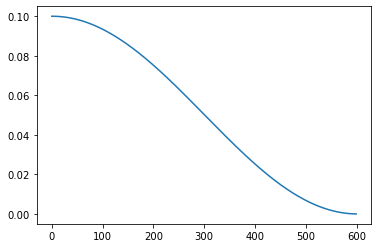

In [29]:
x = np.arange(600)
y = 0.05 * (1.0 + np.cos((x - 1) * (np.pi / 600)))
import matplotlib.pyplot as plt

plt.plot(x, y)
plt.show()

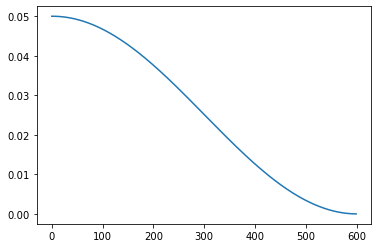

In [32]:
y = [0.05 * lr_lambda(e) for e in x]
plt.plot(x, y)
plt.show()

# Arguments

In [26]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../datasets", type=str)
parser.add_argument("-D", "--dataset", default="cifar10", type=str, help="available [ubs8k | cifar10]")

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("--model", default="Pmodel", type=str)
group_t.add_argument("--supervised_ratio", default=0.08, type=float)
# parser.add_argument("--supervised_mult", default=1.0, type=float)
group_t.add_argument("--batch_size", default=100, type=int)
group_t.add_argument("--nb_epoch", default=600, type=int)
group_t.add_argument("--learning_rate", default=0.05, type=int)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)


group_u = parser.add_argument_group("UrbanSound8k parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4, 5, 6, 7, 8, 9], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[10], type=int)

group_h = parser.add_argument_group('hyperparameters')
group_h.add_argument("--lambda_cot_max", default=10, type=float)
group_h.add_argument("--lambda_diff_max", default=0.5, type=float)
group_h.add_argument("--warmup_length", default=80, type=int)
group_h.add_argument("--epsilon", default=0.02, type=float)

group_a = parser.add_argument_group("Augmentation")
group_a.add_argument("--augment", action="append", help="augmentation. use as if python script")
group_a.add_argument("--augment_S", action="store_true", help="Apply augmentation on Supervised part")
group_a.add_argument("--augment_U", action="store_true", help="Apply augmentation on Unsupervised part")

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="deep-co-training", type=str)
group_l.add_argument("--tensorboard_path", default="deep-co-training", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args = parser.parse_args("")

tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

# Initialization

In [5]:
reset_seed(args.seed)

# Prepare the dataset

In [6]:
"""
we pre-processed the images using ZCA and augmented the dataset using horizontal flips and random translations. The translations
were drawn from [−2, 2] pixels,
"""
extra_train_transforms = [
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
]

manager, train_loader, val_loader = load_dataset(
    args.dataset,
    "dct",
    
    extra_train_transform = extra_train_transforms,
    
    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    verbose = 2
)

Files already downloaded and verified
Files already downloaded and verified


# Models

In [7]:
torch.cuda.empty_cache()
model_func = get_model_from_name(args.model)

m1, m2 = model_func(manager=manager), model_func(manager=manager)

m1 = m1.cuda()
m2 = m2.cuda()

# training parameters

In [8]:
# tensorboard
tensorboard_title = "%s_%s_%.1fS" % (get_datetime(), model_func.__name__, args.supervised_ratio)
checkpoint_title = "%s_%.1fS" % (model_func.__name__, args.supervised_ratio)
tensorboard = SummaryWriter(log_dir="%s/%s" % (tensorboard_path, tensorboard_title), comment=model_func.__name__)
print(os.path.join(tensorboard_path, tensorboard_title))

../tensorboard/cifar10/deep-co-training/2020-08-28_11:41:02_Pmodel_0.1S


## cifar10 optimizer

In [30]:
if args.dataset == "cifar10":
    params = list(m1.parameters()) + list(m2.parameters())
    optimizer = torch.optim.SGD(params, lr=0.05, momentum=0.9, weight_decay=0.0001)
    
    lr_lambda = lambda epoch: (1.0 + np.cos((epoch-1)*np.pi/args.nb_epoch))
    


## ubs8k optimizer

In [10]:
if args.dataset == "ubs8k":
    params = list(m1.parameters()) + list(m2.parameters())
    optimizer = torch.optim.Adam(params, lr=args.learning_rate)
    lr_lambda = lambda epoch: (1.0 + numpy.cos((epoch-1)*numpy.pi/args.nb_epoch)) * 0.5

## Adversarial generator

In [11]:
# adversarial generation
adv_generator_1 = GradientSignAttack(
    m1, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=args.epsilon, clip_min=0, clip_max=1, targeted=True
)

adv_generator_2 = GradientSignAttack(
    m2, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=args.epsilon, clip_min=0, clip_max=1, targeted=True
)

In [12]:
# Losses
# see losses.py

# define the warmups
lambda_cot = Warmup(args.lambda_cot_max, args.warmup_length, sigmoid_rampup)
lambda_diff = Warmup(args.lambda_diff_max, args.warmup_length, sigmoid_rampup)

# callback
lr_scheduler = LambdaLR(optimizer, lr_lambda)
callbacks = [lr_scheduler, lambda_cot, lambda_diff]

# checkpoints
checkpoint_m1 = CheckPoint(m1, optimizer, mode="max", name="%s/%s_m1.torch" % (checkpoint_path, checkpoint_title))

# metrics
metrics_fn = dict(
    ratio_s=[Ratio(), Ratio()],
    ratio_u=[Ratio(), Ratio()],
    acc_s=[CategoricalAccuracy(), CategoricalAccuracy()],
    acc_u=[CategoricalAccuracy(), CategoricalAccuracy()],
    f1_s=[FScore(), FScore()],
    f1_u=[FScore(), FScore()],
    
    avg_total=ContinueAverage(),
    avg_sup=ContinueAverage(),
    avg_cot=ContinueAverage(),
    avg_diff=ContinueAverage(),
)

def reset_metrics():
    for item in metrics_fn.values():
        if isinstance(item, list):
            for f in item:
                f.reset()
        else:
            item.reset()

In [13]:
reset_metrics()

## Can resume previous training

In [14]:
if args.resume:
    checkpoint_m1.load_last()

## Metrics and hyperparameters

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def maximum():
    def func(key, value):
        if key not in func.max:
            func.max[key] = value
        else:
            if func.max[key] < value:
                func.max[key] = value
        return func.max[key]

    func.max = dict()
    return func
maximum_fn = maximum()

# Training functions

In [16]:
UNDERLINE_SEQ = "\033[1;4m"
RESET_SEQ = "\033[0m"

header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} | {:<6.6} | {:<6.6} | {:<6.6} - {:<9.9} {:<9.9} | {:<9.9}- {:<6.6}"
value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} | {:<6.4f} | {:<6.4f} | {:<6.4f} - {:<9.9} {:<9.4f} | {:<9.4f}- {:<6.4f}"

header = header_form.format(
    "", "Epoch", "%", "Losses:", "Lsup", "Lcot", "Ldiff", "total", "metrics: ", "acc_s1", "acc_u1","Time"
)

train_form = value_form
val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

print(header)

         Epoch  - %      - Losses:  Lsup   | Lcot   | Ldiff  | total  - metrics:  acc_s1    | acc_u1   - Time  


In [17]:
def train(epoch):
    start_time = time.time()
    print("")

    reset_metrics()
    m1.train()
    m2.train()

    for batch, (S1, S2, U) in enumerate(train_loader):
        x_s1, y_s1 = S1
        x_s2, y_s2 = S2
        x_u, y_u = U

        x_s1, x_s2, x_u = x_s1.cuda(), x_s2.cuda(), x_u.cuda()
        y_s1, y_s2, y_u = y_s1.cuda(), y_s2.cuda(), y_u.cuda()

        logits_s1 = m1(x_s1)
        logits_s2 = m2(x_s2)
        logits_u1 = m1(x_u)
        logits_u2 = m2(x_u)

        # pseudo labels of U
        pred_u1 = torch.argmax(logits_u1, 1)
        pred_u2 = torch.argmax(logits_u2, 1)

        # ======== Generate adversarial examples ========
        # fix batchnorm ----
        m1.eval()
        m2.eval()

        #generate adversarial examples ----
        adv_data_s1 = adv_generator_1.perturb(x_s1, y_s1)
        adv_data_u1 = adv_generator_1.perturb(x_u, pred_u1)

        adv_data_s2 = adv_generator_2.perturb(x_s2, y_s2)
        adv_data_u2 = adv_generator_2.perturb(x_u, pred_u2)

        m1.train()
        m2.train()

        # predict adversarial examples ----
        adv_logits_s1 = m1(adv_data_s2)
        adv_logits_s2 = m2(adv_data_s1)

        adv_logits_u1 = m1(adv_data_u2)
        adv_logits_u2 = m2(adv_data_u1)

        # ======== calculate the differents loss ========
        # zero the parameter gradients ----
        optimizer.zero_grad()
        m1.zero_grad()
        m2.zero_grad()

        # losses ----
        l_sup = loss_sup(logits_s1, logits_s2, y_s1, y_s2)

        l_cot = loss_cot(logits_u1, logits_u2)

        l_diff = loss_diff(
            logits_s1, logits_s2, adv_logits_s1, adv_logits_s2,
            logits_u1, logits_u2, adv_logits_u1, adv_logits_u2
        )

        total_loss = l_sup + lambda_cot() * l_cot + lambda_diff() * l_diff
        total_loss.backward()
        optimizer.step()

        # ======== Calc the metrics ========
        with torch.set_grad_enabled(False):
            # accuracies ----
            pred_s1 = torch.argmax(logits_s1, dim=1)
            pred_s2 = torch.argmax(logits_s2, dim=1)

            acc_s1 = metrics_fn["acc_s"][0](pred_s1, y_s1)
            acc_s2 = metrics_fn["acc_s"][1](pred_s2, y_s2)
            acc_u1 = metrics_fn["acc_u"][0](pred_u1, y_u)
            acc_u2 = metrics_fn["acc_u"][1](pred_u2, y_u)

            # ratios  ----
            adv_pred_s1 = torch.argmax(adv_logits_s1, 1)
            adv_pred_s2 = torch.argmax(adv_logits_s2, 1)
            adv_pred_u1 = torch.argmax(adv_logits_u1, 1)
            adv_pred_u2 = torch.argmax(adv_logits_u2, 1)

            ratio_s1 = metrics_fn["ratio_s"][0](adv_pred_s1, y_s1)
            ratio_s2 = metrics_fn["ratio_s"][0](adv_pred_s2, y_s2)
            ratio_u1 = metrics_fn["ratio_s"][0](adv_pred_u1, y_u)
            ratio_u2 = metrics_fn["ratio_s"][0](adv_pred_u2, y_u)
            # ========

            avg_total = metrics_fn["avg_total"](total_loss.item())
            avg_sup = metrics_fn["avg_sup"](l_sup.item())
            avg_diff = metrics_fn["avg_diff"](l_diff.item())
            avg_cot = metrics_fn["avg_cot"](l_cot.item())

            # logs
            print(train_form.format(
                "Training: ",
                epoch + 1,
                int(100 * (batch + 1) / len(train_loader)),
                "", avg_sup.mean, avg_cot.mean, avg_diff.mean, avg_total.mean,
                "", acc_s1.mean, acc_u1.mean,
                time.time() - start_time
            ), end="\r")


    # using tensorboard to monitor loss and acc\n",
    tensorboard.add_scalar('train/total_loss', avg_total.mean, epoch)
    tensorboard.add_scalar('train/Lsup', avg_sup.mean, epoch )
    tensorboard.add_scalar('train/Lcot', avg_cot.mean, epoch )
    tensorboard.add_scalar('train/Ldiff', avg_diff.mean, epoch )
    tensorboard.add_scalar("train/acc_1", acc_s1.mean, epoch )
    tensorboard.add_scalar("train/acc_2", acc_s2.mean, epoch )

    tensorboard.add_scalar("detail_acc/acc_s1", acc_s1.mean, epoch)
    tensorboard.add_scalar("detail_acc/acc_s2", acc_s2.mean, epoch)
    tensorboard.add_scalar("detail_acc/acc_u1", acc_u1.mean, epoch)
    tensorboard.add_scalar("detail_acc/acc_u2", acc_u2.mean, epoch)

    tensorboard.add_scalar("detail_ratio/ratio_s1", ratio_s1.mean, epoch)
    tensorboard.add_scalar("detail_ratio/ratio_s2", ratio_s2.mean, epoch)
    tensorboard.add_scalar("detail_ratio/ratio_u1", ratio_u1.mean, epoch)
    tensorboard.add_scalar("detail_ratio/ratio_u2", ratio_u2.mean, epoch)

    # Return the total loss to check for NaN
    return total_loss.item()

In [18]:
def test(epoch, msg = ""):
    start_time = time.time()
    print("")

    reset_metrics()
    m1.eval()
    m2.eval()

    with torch.set_grad_enabled(False):
        for batch, (X, y) in enumerate(val_loader):
            x = X.cuda()
            y = y.cuda()

            logits_1 = m1(x)
            logits_2 = m2(x)

            # losses ----
            l_sup = loss_sup(logits_1, logits_2, y, y)

            # ======== Calc the metrics ========
            # accuracies ----
            pred_1 = torch.argmax(logits_1, dim=1)
            pred_2 = torch.argmax(logits_2, dim=1)

            acc_1 = metrics_fn["acc_s"][0](pred_1, y)
            acc_2 = metrics_fn["acc_s"][1](pred_2, y)

            avg_sup = metrics_fn["avg_sup"](l_sup.item())

            # logs
            print(val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (batch + 1) / len(train_loader)),
                "", avg_sup.mean, 0.0, 0.0, avg_sup.mean,
                "", acc_1.mean, 0.0,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("val/acc_1", acc_1.mean, epoch)
    tensorboard.add_scalar("val/acc_2", acc_2.mean, epoch)
        
    tensorboard.add_scalar("max/acc_1", maximum_fn("acc_1", acc_1.mean), epoch )
    tensorboard.add_scalar("max/acc_2", maximum_fn("acc_2", acc_2.mean), epoch )
    
    tensorboard.add_scalar("detail_hyperparameters/lambda_cot", lambda_cot(), epoch)
    tensorboard.add_scalar("detail_hyperparameters/lambda_diff", lambda_diff(), epoch)
    tensorboard.add_scalar("detail_hyperparameters/learning_rate", get_lr(optimizer), epoch)

    # Apply callbacks
    for c in callbacks:
        c.step()

    # call checkpoint
    checkpoint_m1.step(acc_1.mean)


In [ ]:
print(header)

for epoch in range(0, args.nb_epoch):
    total_loss = train(epoch)
    
    if np.isnan(total_loss):
        print("Losses are NaN, stoping the training here")
        break
        
    test(epoch)

    tensorboard.flush()
    
tensorboard.close()

         Epoch  - %      - Losses:  Lsup   | Lcot   | Ldiff  | total  - metrics:  acc_s1    | acc_u1   - Time  

Training 1      - 100    -          4.4859 | 0.0112 | 4.4796 | 6.8377 -           0.1555    | 0.1513   - 237.2291
Validati 1      - 20     -          4.3388 | 0.0000 | 0.0000 | 4.3388 -           0.1466    | 0.0000   - 6.4963
 better performance: saving ...

Training 2      - 100    -          4.3484 | 0.0346 | 4.5440 | 4.3684 -           0.1600    | 0.1728   - 238.6292
Validati 2      - 20     -          4.1571 | 0.0000 | 0.0000 | 4.1571 -           0.1867    | 0.0000   - 6.5481
 better performance: saving ...

Training 3      - 100    -          4.2099 | 0.0424 | 4.4894 | 4.2329 -           0.1833    | 0.1928   - 238.4541
Validati 3      - 20     -          3.9201 | 0.0000 | 0.0000 | 3.9201 -           0.2265    | 0.0000   - 6.5269
 better performance: saving ...

Training 4      - 100    -          4.1224 | 0.0399 | 4.3997 | 4.1477 -           0.2040    | 0.2099   - 238.0